In [2]:
from typing import List
import numpy as np
import scipy.special as sp_spec
import numpy.random as np_rand
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import tqdm
import seaborn as sns

# Bernoulli Mixture Model - CAVI and SVI
See the solution pdf for derivation of CAVI updates, ELBO and for notation used throughout the notebook. See theory part of Exercise problems for algorithm psuedo code and more. Updates are written using for-loops to more clearly show relation to derivations, however, you are recommended to use matrix operations.


In [2]:
def generate_data_and_priors(N: int, D: int, K: int, theta_a: float, theta_b: float, pi_alpha: List[int]):
  """
  Generates datapoints and hidden variables given parameters for the priors.
  :param N: Number of datapoints
  :param D: Data dimension.
  :param K: Number of mixture components.
  :param theta_a: "a" parameter of the Beta(a,b) prior on theta.
  :param theta_b: "b" parameter of the Beta(a,b) prior on theta.
  :param pi_alpha: parameter of the Dirichlet(alpha) prior on pi.
  :return:
  """
  theta = np_rand.beta(theta_a, theta_b, size=(K,D))  # K x D matrix
  pi = np_rand.dirichlet(pi_alpha) # size K array
  x = np.zeros((N,D)) # N x D matrix
  z = np.zeros(N)     # size N array 
  for n in range(N):
    z_n = np_rand.multinomial(1, pi).argmax() # for each datapoint n, sample the component assignment/class variable
    x_n = np.zeros(D)
    for d in range(D): 
      x_n[d] = np_rand.binomial(1, theta[z_n, d]) # Sample x_nd from Bernoulli(theta_kd)
    z[n] = z_n
    x[n, :] = x_n

  return x, z, theta, pi

def generate_data(N: int, D: int, K: int, theta: np.ndarray , pi: np.ndarray):
  """
   Generates datapoints given values of the hidden variables. Can be used for more "control" of experiments.
  :param N: Number of datapoints
  :param D: Data dimension.
  :param K: Number of mixture components.
  :param theta: Values of theta.
  :param pi: Value of pi.
  :return:
  """
  x = np.zeros((N,D)) # N x D matrix
  z = np.zeros(N)     # size N array
  for n in range(N):
    z_n = np_rand.multinomial(1, pi).argmax() # for each datapoint n, sample the component assignment/class variable
    x_n = np.zeros(D)
    for d in range(D):
      x_n[d] = np_rand.binomial(1, theta[z_n, d])
    z[n] = z_n
    x[n, :] = x_n

  return x, z, theta, pi

# Test the functions by running for some simple cases and verify that data and variables look as expected.
N = 1000
D = 3
K = 2

theta = np.array([[0.1, 0.7, 0.2], [0.6, 0.2, 0.2]])
pi = np.array([0.4, 0.6])
x, z, theta, pi = generate_data(N, D, K, theta, pi)
print(f"First 3 datapoints: {x[0:3, 0:5]}")
print(f"First 3 z: {z[0:3]}")

x_mean = np.mean(x, axis=0)
print(f"Mean of x: {x_mean}")
print(f"Expected x: {pi[0] * theta[0] + pi[1] * theta[1]}")
z_one_hot = np.eye(K)[z.astype(int)]
print(f"Mean of z: {np.mean(z_one_hot, axis=0)}")
print(f"Expected z: {pi}")

First 3 datapoints: [[1. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
First 3 z: [1. 0. 0.]
Mean of x: [0.377 0.422 0.189]
Expected x: [0.4 0.4 0.2]
Mean of z: [0.44 0.56]
Expected z: [0.4 0.6]


## Initialization and ELBO calculation

Initialization strategy and ELBO calculation are the save for CAVI and SVI algorithms so we define them first.

### Helper functions

In [3]:
def multivariate_beta_function(a):
    eps = 0.0001  # for numerical stability to avoid -inf
    return np.exp(np.sum(sp_spec.gammaln(a + eps) - sp_spec.gammaln(np.sum(a + eps))))

In [4]:
def initialize_q(x, K):
    N, D = x.shape
    kmeans =  KMeans(n_clusters=K, random_state=0, n_init=30).fit(x)
    labels = kmeans.labels_
    a_q_init = np.zeros((K, D))
    b_q_init = np.zeros((K, D))
    for k in range(K):
        x_k = x[labels == k]
        a_q_init[k, :] = np.mean(x_k, axis=0) + 1
        b_q_init[k, :] = np.mean(1 - x_k, axis=0) + 1

    r_q_init = np.random.rand(N, K)
    r_q_init = r_q_init / np.sum(r_q_init, axis=1, keepdims=True)  # normalize
    a_q_init = np.random.randint(1, 100, size=(K,D))
    b_q_init = np.random.randint(1, 100, size=(K,D))
    alpha_q_init = np.ones(K)
    return r_q_init, a_q_init, b_q_init, alpha_q_init

def calculate_elbo(x, r_q, a_q, b_q, alpha_q):
    N, D = x.shape
    K = r_q.shape[1]
    E_log_theta = sp_spec.digamma(a_q) - sp_spec.digamma(a_q + b_q)
    E_log_1_minus_theta = sp_spec.digamma(b_q) - sp_spec.digamma(a_q + b_q)
    E_log_pi = sp_spec.digamma(alpha_q) - sp_spec.digamma(np.sum(alpha_q))
    alpha_0 = np.sum(alpha_q)
    CR_likelihood = np.sum(r_q * (np.einsum('nd,kd->nk', x, E_log_theta)
                                  + np.einsum('nd,kd->nk', 1 - x, E_log_1_minus_theta)))
    CR_Z = np.sum(r_q * E_log_pi)
    eps = 0.0001  # for numerical stability to avoid -inf
    CR_pi = -np.log(multivariate_beta_function(alpha_q) + eps) + np.sum((alpha_q - 1) * E_log_pi)
    CR_theta = np.sum((a_q-1) * E_log_theta + (b_q-1) * E_log_1_minus_theta - sp_spec.beta(a_q, b_q))
    H_Z = np.sum(r_q * np.log(r_q + eps))
    H_pi = np.log(multivariate_beta_function(alpha_q) + eps) + (alpha_0 - K) * sp_spec.digamma(alpha_0) - \
           np.sum((alpha_q - 1) * sp_spec.digamma(alpha_q))
    Beta_ab = sp_spec.beta(a_q, b_q) + eps
    H_theta = np.sum(np.log(Beta_ab) - (a_q - 1) * sp_spec.digamma(a_q) -
                     (b_q - 1) * sp_spec.digamma(b_q) + (a_q + b_q + 2) * sp_spec.digamma(a_q + b_q))
    elbo = CR_likelihood + CR_Z + CR_pi + CR_theta + H_Z + H_pi + H_theta
    return elbo

N = 10
K = 5
x = np.random.random((N, K))
r_q_init, a_q_init, b_q_init, alpha_q_init = initialize_q(x, K)

## CAVI update equations and CAVI algorithm

### CAVI update equations

In [5]:
def update_q_theta(x, r_q, a_prior, b_prior):
    E_Z = r_q
    a_star = np.einsum('nk,nd->kd', E_Z, x) + a_prior
    b_star = np.einsum('nk,nd->kd', E_Z, 1 - x) + b_prior
    
    return a_star, b_star

In [6]:
def update_q_Z(x, a_q, b_q, alpha_q):
    """
    Implements the CAVI update equation of q(Z) derived in the solution of the exercise.
    """
    E_log_theta = sp_spec.digamma(a_q) - sp_spec.digamma(a_q + b_q)         # K x D
    E_log_1_minus_theta = sp_spec.digamma(b_q) - sp_spec.digamma(a_q + b_q) # K x D
    E_log_pi = sp_spec.digamma(alpha_q) - sp_spec.digamma(np.sum(alpha_q))  # K array

    log_rho = (np.einsum('nd,kd->nk', x, E_log_theta)
               + np.einsum('nd,kd->nk', 1 - x, E_log_1_minus_theta)
               + E_log_pi)

    r_star = np.exp(log_rho - sp_spec.logsumexp(log_rho, axis=1, keepdims=True))
    return r_star

In [7]:
def update_q_pi(E_Z, alpha_prior):
    alpha_star = np.sum(E_Z, axis=0) + alpha_prior  # size K array
    return alpha_star

### CAVI algorithm

In [8]:
def CAVI_algorithm(x, K, n_iter, a_prior, b_prior, alpha_prior, step_size=0.01, tol=1e-6):
    N, D = x.shape

    r_q, a_q, b_q, alpha_q = initialize_q(x, K)
    elbo_after_init = calculate_elbo(x, r_q, a_q, b_q, alpha_q)
    # Store output per iteration
    elbo = [elbo_after_init]
    r_q_out = [r_q]
    a_q_out = [a_q]
    b_q_out = [b_q]
    alpha_q_out = [alpha_q]

    pbar = tqdm.tqdm(range(n_iter))
    for i in pbar:
        # CAVI updates
        # q(Z) update
        r_star = update_q_Z(x, a_q, b_q, alpha_q)
        r_q += step_size * (r_star - r_q)
        r_q = r_q / np.sum(r_q, axis=1, keepdims=True)  # normalize

        # q(pi) update
        alpha_star = update_q_pi(r_q, alpha_prior)
        alpha_q += step_size * (alpha_star - alpha_q)

        # q(theta) update
        a_star, b_star = update_q_theta(x, r_q, a_prior, b_prior)
        a_q = a_q + step_size * (a_star - a_q)
        b_q = b_q + step_size * (b_star - b_q)

        # ELBO
        elbo.append(calculate_elbo(x, r_q, a_q, b_q, alpha_q))

        # outputs
        r_q_out.append(r_q)
        a_q_out.append(a_q)
        b_q_out.append(b_q)
        alpha_q_out.append(alpha_q)

        pbar.set_description(f"ELBO: {elbo[i]:.2f}")

        if i > 1 and np.abs(elbo[i] - elbo[i-1]) < tol:
            break

    r_q_out = np.array(r_q_out)
    a_q_out = np.array(a_q_out)
    b_q_out = np.array(b_q_out)
    alpha_q_out = np.array(alpha_q_out)
    elbo = np.array(elbo)
    out = {"r_q": r_q_out, "a_q": a_q_out, "b_q": b_q_out, "alpha_q": alpha_q_out, "elbo": elbo}
    return out

### Run CAVI algorithm

In [9]:
N = 1000
D = 100
K = 5
n_iter = 3000
a_prior = 1.
b_prior = 1.
alpha_prior = np.ones(K) * 1.0
# theta = np.array([[0.1, 0.9, 0.0, 0.0], [0.0, 0.05, 0.45, 0.5]])
# pi = np.array([0.6, 0.4])
# x, z, theta, pi = generate_data(N, D, K, theta, pi)
x, z, theta, pi = generate_data_and_priors(N, D, K, a_prior, b_prior, alpha_prior)
out = CAVI_algorithm(x, K, n_iter, a_prior, b_prior, alpha_prior)
r_q_out = out["r_q"]
a_q_out = out["a_q"]
b_q_out = out["b_q"]
alpha_q_out = out["alpha_q"]
elbo = out["elbo"]
np.printoptions(precision=2)
print(f"Print results (check for label switching).")
print(f"z :{z[0:10]}")
# As q(Z) is our variational posterior and is a Categorical, argmax corresponds to our MAP estimates
MAP_assignments = r_q_out[-1].argmax(axis=1)
print(f"r_q :{MAP_assignments[0:10]}")
print(f"ARI :{adjusted_rand_score(z, MAP_assignments)}")  # clustering metric that is independent of label switching

print(f"Expected value pi: {alpha_q_out[-1] / np.sum(alpha_q_out[-1])}")
print(f"True pi: {pi}")

ELBO: -49770.69:  82%|████████▏ | 2447/3000 [00:03<00:00, 757.23it/s]


Print results (check for label switching).
z :[4. 4. 1. 1. 1. 2. 1. 2. 4. 1.]
r_q :[0 0 2 2 2 4 2 4 0 2]
ARI :0.9059224852349239
Expected value pi: [0.15124378 0.06965174 0.48855721 0.00099503 0.28955224]
True pi: [0.17247658 0.49344696 0.12521849 0.07461518 0.1342428 ]


Text(0, 0.5, 'ELBO')

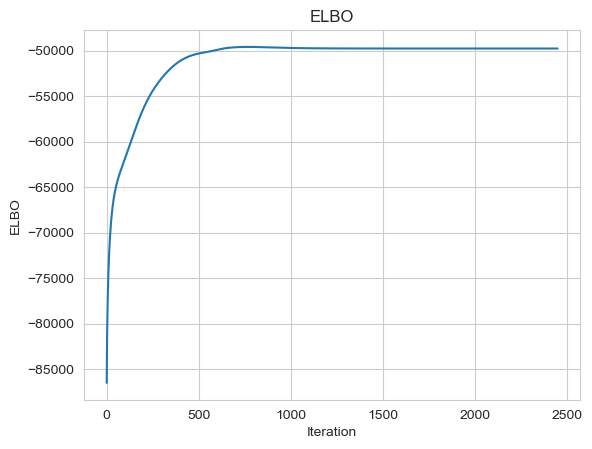

In [10]:
elbo = out["elbo"]
plt.plot(elbo)
plt.title("ELBO")
plt.xlabel("Iteration")
plt.ylabel("ELBO")

## SVI tailored updates and SVI algorithm

### SVI update equations

In [11]:
def update_q_Z_batch(batch, x, a_q, b_q, alpha_q):
    """
    Implements the SVI update equation of q(Z) derived in the solution of the exercise.
    """
    E_log_theta = sp_spec.digamma(a_q) - sp_spec.digamma(a_q + b_q)  # K x D
    E_log_1_minus_theta = sp_spec.digamma(b_q) - sp_spec.digamma(a_q + b_q)  # K x D
    E_log_pi = sp_spec.digamma(alpha_q) - sp_spec.digamma(np.sum(alpha_q))  # K array

    x_batch = x[batch]

    log_rho = (np.einsum('nd,kd->nk', x_batch, E_log_theta)
               + np.einsum('nd,kd->nk', 1 - x_batch, E_log_1_minus_theta)
               + E_log_pi)

    r_star = np.exp(log_rho - sp_spec.logsumexp(log_rho, axis=1, keepdims=True))
    return r_star

In [12]:
def update_q_theta_batch(batch, x, r_q, a_prior, b_prior):
    E_Z = r_q[batch]
    N, D = x.shape
    x_batch = x[batch]
    a_star = np.einsum('nk,nd->nkd', E_Z, x_batch) * N + a_prior
    b_star = np.einsum('nk,nd->nkd', E_Z, 1 - x_batch) * N + b_prior
    return a_star, b_star

In [13]:
def update_q_pi_batch(batch, r_q, alpha_prior):
    E_Z = r_q[batch]
    N, K = r_q.shape
    alpha_star = E_Z * N + alpha_prior  # size K array
    return alpha_star

### SVI algorithm

In [14]:
def SVI_algorithm(x, K, n_iter, a_prior, b_prior, alpha_prior, S=1, tol=1e-6):
    N, D = x.shape

    r_q, a_q, b_q, alpha_q = initialize_q(x, K)
    elbo_after_init = calculate_elbo(x, r_q, a_q, b_q, alpha_q)
    # Store output per iteration
    elbo = [elbo_after_init]
    r_q_out = [r_q]
    a_q_out = [a_q]
    b_q_out = [b_q]
    alpha_q_out = [alpha_q]

    # Step size schedule
    delay = 10 # int(n_iter/10)
    forgetting_rate = 0.5
    rho = lambda t: (t + delay) ** (-forgetting_rate)

    pbar = tqdm.tqdm(range(n_iter))
    for i in pbar:
        # sample datapoint and set step size, rho. We are only considering batch size
        batch = np.random.randint(0, N, size=S)
        rho_t = rho(i)

        ####### SVI updates
        # Local updates
        r_star = update_q_Z_batch(batch, x, a_q, b_q, alpha_q)
        r_q[batch] = (1 - rho_t)*r_q[batch] + rho_t * (r_star - r_q[batch])
        r_q[batch] = r_q[batch] / np.sum(r_q[batch], axis=1, keepdims=True)  # normalize

        # Global updates
        # q(theta) update
        a_star_batch, b_star_batch = update_q_theta_batch(batch, x, r_q, a_prior, b_prior)
        a_q = (1 - rho_t) * a_q + rho_t/S * np.sum(a_star_batch, axis=0)  # Note this is simplifies to step 7. in fig 4. in Hoffman when S=1
        b_q = (1 - rho_t) * b_q + rho_t/S * np.sum(b_star_batch, axis=0)

        # q(pi) update
        alpha_star_batch = update_q_pi_batch(batch, r_q, alpha_prior)
        alpha_q = (1 - rho_t) * alpha_q + rho_t/S * np.sum(alpha_star_batch, axis=0)

        # ELBO
        elbo.append(calculate_elbo(x, r_q, a_q, b_q, alpha_q))

        # outputs
        r_q_out.append(r_q)
        a_q_out.append(a_q)
        b_q_out.append(b_q)
        alpha_q_out.append(alpha_q)

        pbar.set_description(f"ELBO: {elbo[i]:.2f}, rho_t: {rho_t:.2f}")

        if i > 1 and np.abs(elbo[i] - elbo[i - 1]) < tol:
            break

    r_q_out = np.array(r_q_out)
    a_q_out = np.array(a_q_out)
    b_q_out = np.array(b_q_out)
    alpha_q_out = np.array(alpha_q_out)
    elbo = np.array(elbo)
    out = {"r_q": r_q_out, "a_q": a_q_out, "b_q": b_q_out, "alpha_q": alpha_q_out, "elbo": elbo}
    return out


### Run SVI algorithm

In [15]:
# Run optimization
"""
Run and tweak the parameters and examine the outcomes. How does N effect the variational posteriors/distributions?
How does the priors effect the variational posteriors? What happens if the theta_k:s are closer together?
"""
# Set hyper parameters
N = 1000
D = 500
K = 5
S = int(N/10)
n_iter = 2000

# Simulate data
a_sim = 1.
b_sim = 1.
alpha_sim = np.ones(K) * 1.0
x, z, theta, pi = generate_data_and_priors(N, D, K, a_sim, b_sim, alpha_sim)

# Set priors and run SVI
a_prior = 1.
b_prior = 1.
alpha_prior = np.ones(K) * 10.0

out_svi = SVI_algorithm(x, K, n_iter, a_prior, b_prior, alpha_prior, S=S)


ELBO: -228493.13, rho_t: 0.02: 100%|██████████| 2000/2000 [00:09<00:00, 216.14it/s]


In [16]:
a_q_out = out_svi["a_q"]
b_q_out = out_svi["b_q"]
alpha_q_out = out_svi["alpha_q"]
elbo_svi = out_svi["elbo"]

# Check output
np.printoptions(precision=2)
print(f"Print results (check for label switching).")
# As q(Z) is our variational posterior and is a Categorical, argmax corresponds to our MAP estimates
MAP_assignments = out_svi['r_q'][-1].argmax(axis=1)
print(f"q(Z) MAP: {MAP_assignments[0:10]}")
print(f"ARI: {adjusted_rand_score(z, MAP_assignments)}")   # clustering metric that is independent of label switching
print(f"E_q[theta_k0]: {a_q_out[-1][:, 0] / (a_q_out[-1][:, 0] + b_q_out[-1][:, 0])}")  # E_q[theta] = a / (a + b) from expected value of Beta r.v.
print(f"True theta d=0: {theta[:, 0]}")
print(f"E_q[pi]: {alpha_q_out[-1] / np.sum(alpha_q_out[-1])}")
print(f"True pi: {pi}")

Print results (check for label switching).
q(Z) MAP: [0 4 2 2 2 2 2 4 2 2]
ARI: 1.0
E_q[theta_k0]: [0.33019599 0.74421725 0.30987495 0.36853007 0.69911893]
True theta d=0: [0.42314286 0.73733087 0.28184772 0.72106068 0.34719597]
E_q[pi]: [0.13927739 0.04793344 0.48304893 0.04009261 0.28964763]
True pi: [0.03752377 0.30083435 0.13432567 0.04115858 0.48615763]


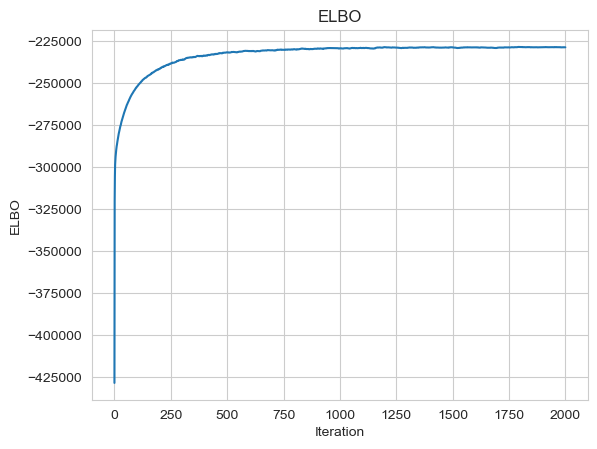

In [17]:
elbo_svi = out_svi["elbo"]
plt.plot(elbo_svi)
plt.title("ELBO")
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.show()

## SVI vs CAVI comparisons
Here we run experiments on simulated data using the CAVI algorithm and SVI algorithm. The algorithms are then compared in terms of runtime, ELBO and relation to true parameters.
Notice, for some configurations of the simulated data, SVI is both faster and yields better accuracy. Particularly, SVI is substantially faster for large N (approx. > 10**4) and large K (approx. K > 5). In practice, the batch size S is required to be larger than 1 to get good convergence and SVI needs to run for more iterations than SVI. The benefits of SVI are more clear for more complicated models, e.g. Topic models, than for this rather simple Beroulli mixture model.

### Simulate data
Simulate data and latent variables and parameters from priors

In [18]:
import time
data_seed = 0
np.random.seed(data_seed)
N = 10**4
D = 5 * 10**2
evenly_spread_out_cluster_components = False
K = 7

# Data generation parameters
pi_alpha_sim = np.ones(K) * 3.

if evenly_spread_out_cluster_components: # Use to avoid clusters being too similar for accurate clustering
  theta = np.linspace(0, 1, K)
  pi = np_rand.dirichlet(pi_alpha_sim)
  x, z, theta, pi = generate_data(N, D, K, theta, pi)
else:
  theta_a_sim = 1.
  theta_b_sim = 1.
  x, z, theta, pi = generate_data_and_priors(N, D, K, theta_a_sim, theta_b_sim, pi_alpha_sim)

print("Sanity check on clusters: if theta's are too close clustering will be difficult")
print(f"Sampled theta: {theta}")
print(f"Sampled pi: {pi}")

Sanity check on clusters: if theta's are too close clustering will be difficult
Sampled theta: [[0.44912526 0.02370719 0.15599464 ... 0.61419174 0.77044003 0.08501802]
 [0.16314497 0.369553   0.81238762 ... 0.19531436 0.11831369 0.77513058]
 [0.40636513 0.54399896 0.87967511 ... 0.3363141  0.27949696 0.65394034]
 ...
 [0.22640358 0.78160409 0.19629046 ... 0.28081294 0.60108466 0.74056901]
 [0.55382019 0.32990988 0.53276071 ... 0.09242139 0.00999927 0.97094594]
 [0.08021106 0.20751691 0.88066712 ... 0.52689195 0.74227072 0.94281283]]
Sampled pi: [0.23934209 0.21683263 0.22910859 0.08208506 0.04418532 0.07955513
 0.10889117]


### Run the SVI algorithm and CAVI algorithm and measure time elapsed

In [19]:
# Set hyper parameters
S = np.max([1, int(N/20)])         # batch size
n_iter_svi = 100
n_iter_cavi = 100

a_prior = 1.
b_prior = 1.
alpha_prior = np.ones(K) * 3.0

start_svi = time.time()
out_svi = SVI_algorithm(x, K, n_iter_svi, a_prior, b_prior, alpha_prior, S=S)
end_svi = time.time()

start_cavi = time.time()
out = CAVI_algorithm(x, K, n_iter_cavi, a_prior, b_prior, alpha_prior)
end_cavi = time.time()

ELBO: -3129427.78: 100%|██████████| 100/100 [00:07<00:00, 13.48it/s]


In [20]:
print(f"Time SVI: {end_svi - start_svi}")
print(f"Time CAVI: {end_cavi - start_cavi}")

r_q_out_svi = out_svi["r_q"]
r_q_out_cavi = out["r_q"]
MAP_assignments_svi = r_q_out_svi[-1].argmax(axis=1)
MAP_assignments_cavi = r_q_out_cavi[-1].argmax(axis=1)
print(f"ARI SVI: {adjusted_rand_score(z, MAP_assignments_svi)}")
print(f"ARI CAVI: {adjusted_rand_score(z, MAP_assignments_cavi)}")

Time SVI: 5.249811887741089
Time CAVI: 8.531572103500366
ARI SVI: 0.935323112707255
ARI CAVI: 0.7752215188389203


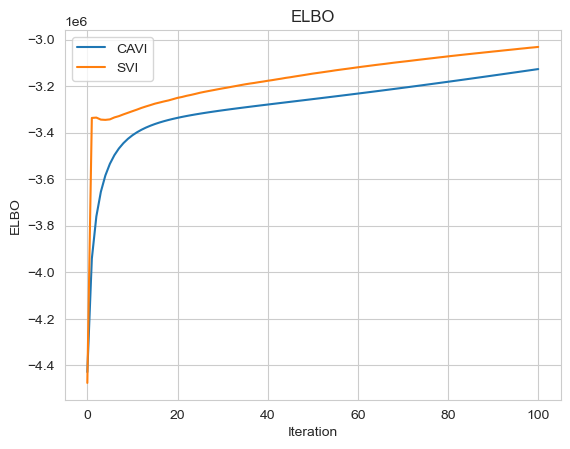

In [21]:
elbo = out["elbo"]
elbo_svi = out_svi["elbo"]
plt.plot(elbo)
plt.plot(elbo_svi)
plt.legend(["CAVI", "SVI"])
plt.title("ELBO")
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.show()

In [22]:
# Compare true parameters with variational output
a_q_out_svi = out_svi["a_q"]
b_q_out_svi = out_svi["b_q"]
alpha_q_out_svi = out_svi["alpha_q"]
a_q_out_cavi = out["a_q"]
b_q_out_cavi = out["b_q"]
alpha_q_out_cavi = out["alpha_q"]

print(f"E_q[theta] SVI: {a_q_out_svi[-1] / (a_q_out_svi[-1] + b_q_out_svi[-1])}")
print(f"E_q[theta] CAVI: {a_q_out_cavi[-1] / (a_q_out_cavi[-1] + b_q_out_cavi[-1])}")
print(f"True theta: {theta}")
print(f"E_q[pi] SVI: {alpha_q_out_svi[-1] / np.sum(alpha_q_out_svi[-1])}")
print(f"E_q[pi] CAVI: {alpha_q_out_cavi[-1] / np.sum(alpha_q_out_cavi[-1])}")
print(f"True pi: {pi}")

E_q[theta] SVI: [[0.41655916 0.33064589 0.54193837 ... 0.27246046 0.24874826 0.74815265]
 [0.396772   0.10591304 0.26406662 ... 0.57209506 0.68196761 0.21440613]
 [0.38408572 0.47758947 0.78016752 ... 0.37199802 0.32844142 0.63679053]
 ...
 [0.18127232 0.37765603 0.31661517 ... 0.58036232 0.70239369 0.29318986]
 [0.22139504 0.34976438 0.62578944 ... 0.45234934 0.59409855 0.75169915]
 [0.30623775 0.32090825 0.55076442 ... 0.42637835 0.46032998 0.54004107]]
E_q[theta] CAVI: [[0.34684497 0.21124533 0.32570177 ... 0.55667993 0.65556137 0.26382347]
 [0.25183523 0.35928526 0.68497136 ... 0.31980244 0.28559961 0.65598818]
 [0.36772657 0.34594344 0.5733673  ... 0.32371978 0.35204919 0.6512992 ]
 ...
 [0.27906301 0.36489901 0.71766107 ... 0.41985224 0.47220722 0.66871389]
 [0.33904333 0.35538675 0.55610659 ... 0.42328182 0.45764232 0.51221011]
 [0.34082645 0.35575063 0.56136622 ... 0.39500439 0.44406842 0.54458497]]
True theta: [[0.44912526 0.02370719 0.15599464 ... 0.61419174 0.77044003 0.0850

## SVI on MNIST

Now we can run on a larger dataset than for the CAVI algorithm. Let's try some larger N and larger K. 

In [29]:
from sklearn.datasets import fetch_openml
np.random.seed(0)
mnist = fetch_openml('mnist_784')
X = mnist.data
y = mnist.target
X = X.to_numpy()

selected_digits = [0, 1, 2, 3, 4, 5]
train_filter = []
K_true = len(selected_digits)
N_k = np.array([1000] * K_true) * 5
for k, s in enumerate(selected_digits):
    train_filter.append(np.where(y == str(s))[0][0:N_k[k]])

train_filter = np.concatenate(train_filter)
X = X[train_filter, :]
y = y[train_filter]
N = len(train_filter)
X = X[0:N, :]
X = (X > 127.5).astype(int)  # binarize

In [30]:
N, D = X.shape
S = 500
K = K_true
n_iter = 2000
a_prior = 1.
b_prior = 1.
alpha_prior = np.ones(K) * N/K

print(f"Priors: {alpha_prior}")
print(f"Number of iterations: {n_iter}")
print(f"Number of datapoints: {N}")
print(f"Batch size: {S}")
out_svi_mnist = SVI_algorithm(X, K, n_iter, a_prior, b_prior, alpha_prior, S=S)

Priors: [5000.00 5000.00 5000.00 5000.00 5000.00 5000.00]
Number of iterations: 1000
Number of datapoints: 30000
Batch size: 500


ELBO: -5799307.65, rho_t: 0.03: 100%|██████████| 1000/1000 [04:26<00:00,  3.75it/s]


Text(0, 0.5, 'ELBO')

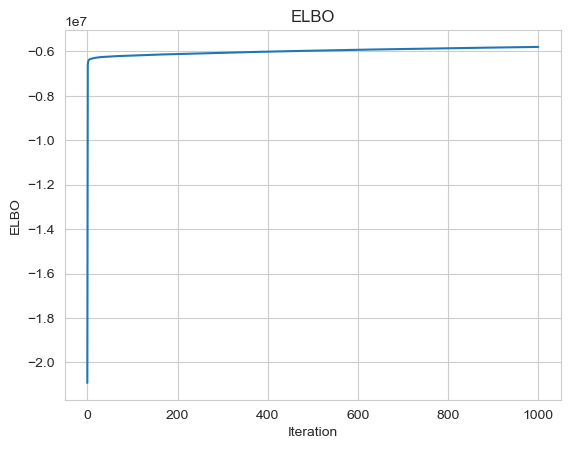

In [31]:
elbo_mnist = out_svi_mnist["elbo"]
plt.plot(elbo_mnist)
plt.title("ELBO")
plt.xlabel("Iteration")
plt.ylabel("ELBO")

In [32]:
r_q_out = out_svi_mnist["r_q"]
a_q_out = out_svi_mnist["a_q"]
b_q_out = out_svi_mnist["b_q"]
alpha_q_out = out_svi_mnist["alpha_q"]
elbo_mnist = out_svi_mnist["elbo"]
np.printoptions(precision=2)

sklearn_kmeans = KMeans(n_clusters=K, random_state=0, n_init=1).fit(X)
labels = sklearn_kmeans.labels_
print(f"ARI KMeans:{adjusted_rand_score(y[0:N], labels)}")  # clustering metric that is independent of label switching

MAP_assignments_svi_mnist = r_q_out[-1].argmax(axis=1)
print(MAP_assignments_svi_mnist.shape)
print(f"MAP assignments: {MAP_assignments_svi_mnist[0:10]}")
print(f"ARI SVI: {adjusted_rand_score(y[0:N], MAP_assignments_svi_mnist)}")

y_labels, y_counts = np.unique(y[0:N], return_counts=True)
print(f"True pi: {y_counts / np.sum(y_counts)}")
print(f"Expected value pi: {alpha_q_out[-1] / np.sum(alpha_q_out[-1])}")

ARI KMeans:0.49741100027588253
(30000,)
MAP assignments: [2 2 4 2 2 2 2 2 2 2]
ARI SVI: 0.47768077565309014
True pi: [0.17 0.17 0.17 0.17 0.17 0.17]
Expected value pi: [0.15 0.15 0.16 0.19 0.16 0.18]


### Visualize components

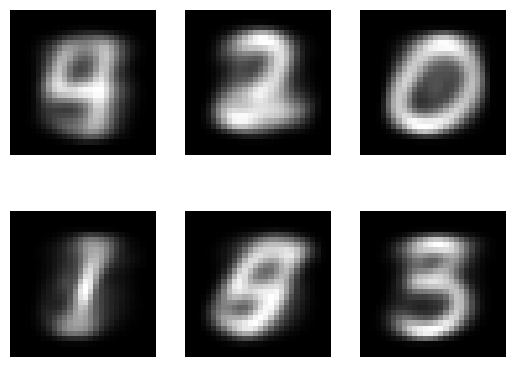

In [33]:
# Plothe E_q[theta_k] for each k
for k in range(K):
    plt.subplot(2, int(K/2) + (K % 2), k + 1)
    E_theta_k = a_q_out[-1][k] / (a_q_out[-1][k] + b_q_out[-1][k])
    plt.imshow(E_theta_k.reshape(28, 28), cmap="gray")
    plt.axis("off")

Probability of most uncertain sample of cluster 0: [0.24 0.11 0.13 0.10 0.13 0.09 0.20]
Probability of most certain sample of cluster 0: [0.89 0.00 0.03 0.01 0.00 0.03 0.04]
Probability of most uncertain sample of cluster 1: [0.14 0.23 0.11 0.13 0.11 0.10 0.17]
Probability of most certain sample of cluster 1: [0.03 0.91 0.01 0.01 0.02 0.02 0.02]
Probability of most uncertain sample of cluster 2: [0.16 0.11 0.19 0.15 0.17 0.15 0.08]
Probability of most certain sample of cluster 2: [0.01 0.09 0.42 0.01 0.35 0.10 0.02]
Probability of most uncertain sample of cluster 3: [0.13 0.12 0.09 0.24 0.16 0.13 0.13]
Probability of most certain sample of cluster 3: [0.01 0.00 0.01 0.94 0.02 0.00 0.02]
Probability of most uncertain sample of cluster 4: [0.12 0.09 0.13 0.11 0.19 0.19 0.18]
Probability of most certain sample of cluster 4: [0.01 0.01 0.01 0.01 0.95 0.01 0.00]
Probability of most uncertain sample of cluster 5: [0.11 0.14 0.16 0.10 0.09 0.21 0.18]
Probability of most certain sample of clus

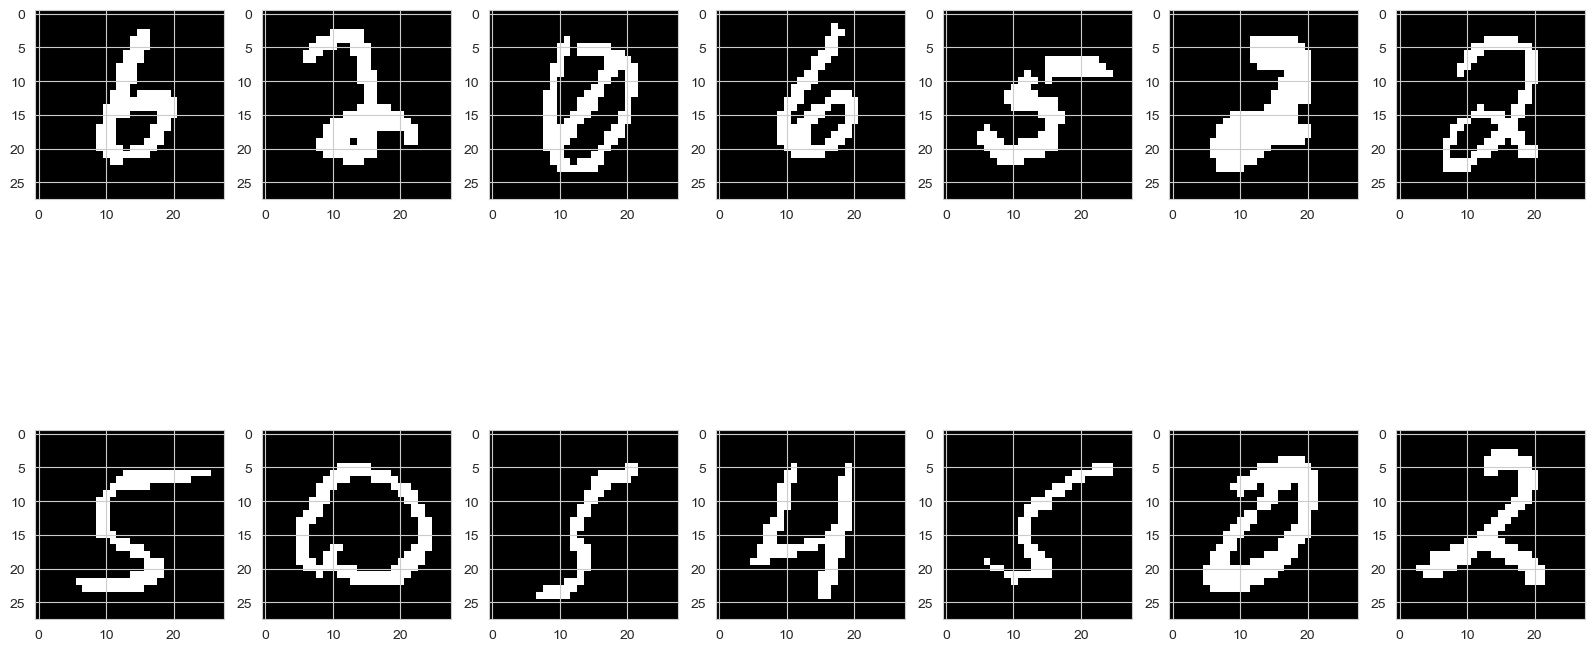

In [28]:
import scipy.stats as sp_stats
# Plot most certain vs uncertain images
fig, axs = plt.subplots(2, K, figsize=(20, 10))
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})
for k in range(K):
    idx_qZ_k = np.where(MAP_assignments_svi_mnist==k)[0]
    max_entropy_idx = np.argmax(sp_stats.entropy(r_q_out[-1][idx_qZ_k], axis=1))
    print(f"Probability of most uncertain sample of cluster {k}: {r_q_out[-1][idx_qZ_k][max_entropy_idx]}")
    min_entropy_idx = np.argmin(sp_stats.entropy(r_q_out[-1][idx_qZ_k], axis=1))
    print(f"Probability of most certain sample of cluster {k}: {r_q_out[-1][idx_qZ_k][min_entropy_idx]}")
    max_entr_img = X[idx_qZ_k][max_entropy_idx]
    min_entr_img = X[idx_qZ_k][min_entropy_idx]
    axs[0, k].imshow(max_entr_img.reshape(28, 28), cmap="gray")
    axs[1, k].imshow(min_entr_img.reshape(28, 28), cmap="gray")